In [1]:
from mgmt.data.nifti import load_subjects
from mgmt.visualize.subject import plot_subject_with_label

import torchio as tio
from mgmt.transforms.rescale_intensity import RescaleIntensity
from mgmt.data.subject_transforms import CropLargestTumor

2023-07-27 22:45:55.908837: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 22:45:56.632820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
subjects = load_subjects(
    "/home/bryan/data/brain_tumor/caidm_3d_240",
    "/home/bryan/data/brain_tumor/classification/train_labels.csv",
    modality=["fla", "t1w", "t1c", "t2w"]
)

In [3]:
for subject in subjects:
    if subject.patient_id_str == "MGMT-006878":
        break

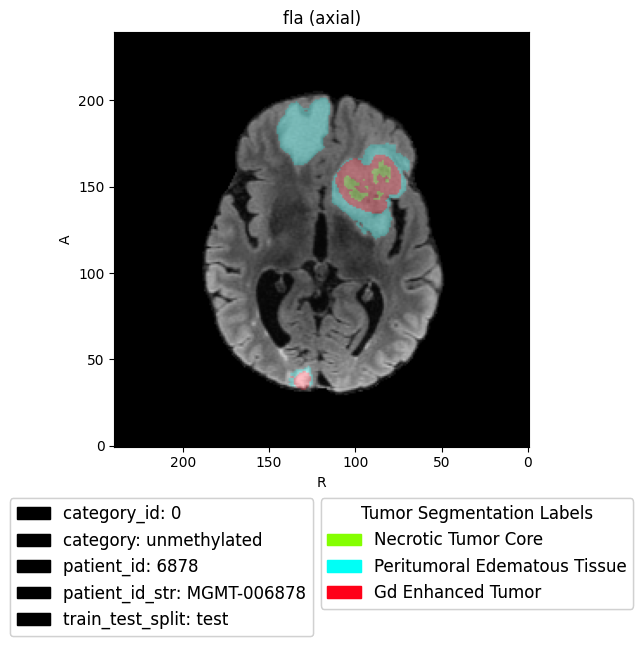

In [4]:
plot_subject_with_label(subject, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

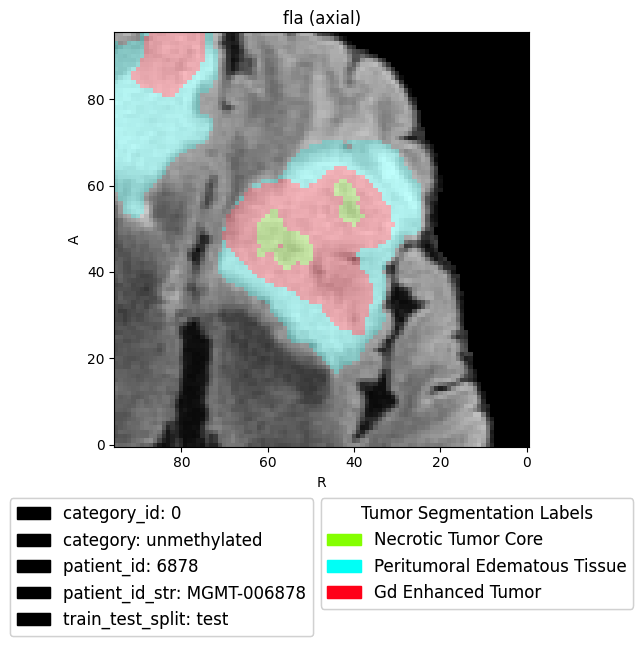

In [5]:
subject = CropLargestTumor(crop_dim=[96, 96, 96])(subject)
plot_subject_with_label(subject, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

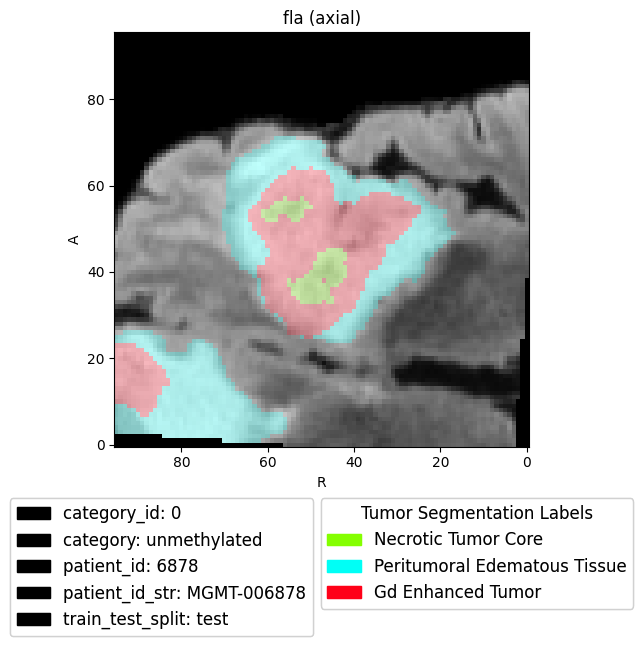

In [6]:
subject_transformed = tio.RandomAffine(
    p = 1.0,
    scales = [1, 1, 1, 1, 1, 1],
    # only rotate about the z-axis (depth)
    degrees = [0, 0, 0, 0, 0, 360]
)(subject)

plot_subject_with_label(subject_transformed, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

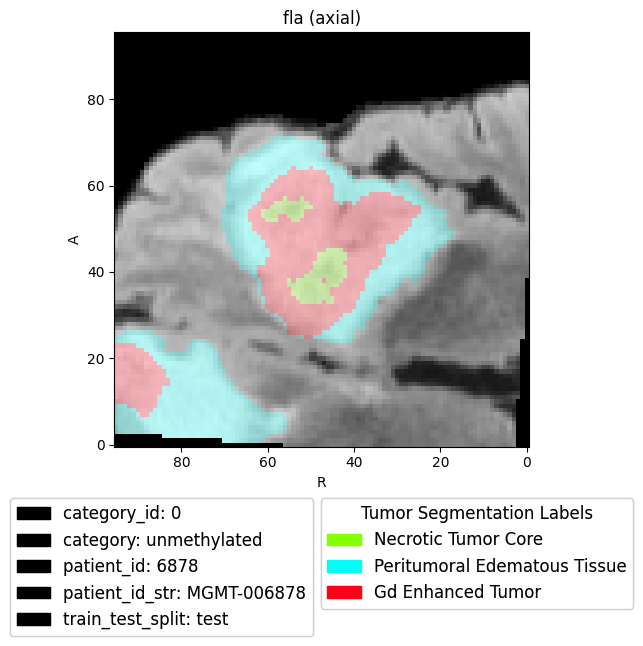

In [7]:
subject_transformed2 = tio.RandomGamma(
    p = 1.0,
    log_gamma = [-0.3, -0.3], # normally would be [-0.3, 0.3]
)(subject_transformed)

plot_subject_with_label(subject_transformed2, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

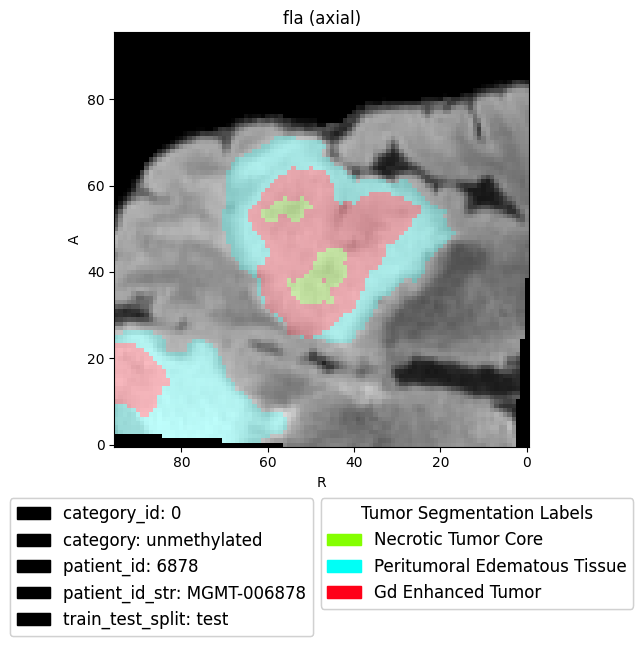

In [9]:
subject_transformed3 = tio.RandomBiasField(
    p = 1.0,
    coefficients = [-0.1, 0.1], # normally would be [-0.1, 0.1]
    order = 3,
)(subject_transformed2)

plot_subject_with_label(subject_transformed3, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

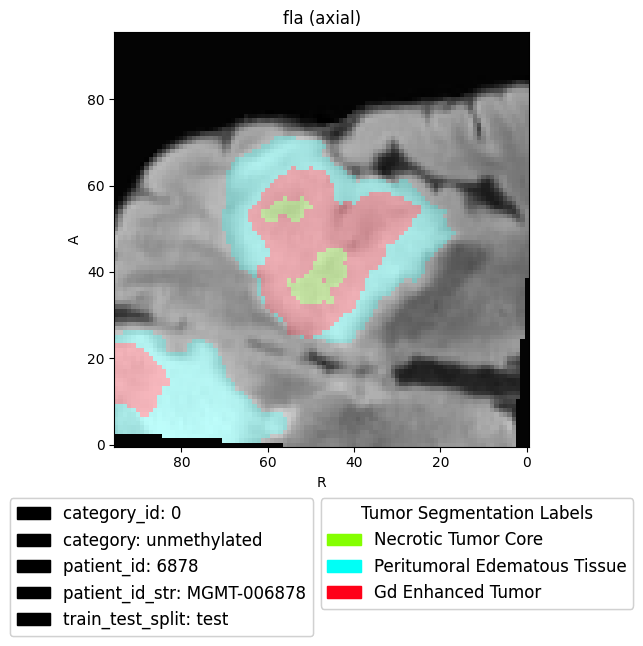

In [32]:
subject_transformed4 = tio.RandomMotion(
    p = 1.0,
    degrees = 45, # usually use smaller range [-1, 1]
    translation = 100, # usually use smaller range [-1, 1]
    num_transforms = 2,
    image_interpolation = "linear"
)(subject_transformed3)

plot_subject_with_label(subject_transformed4, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

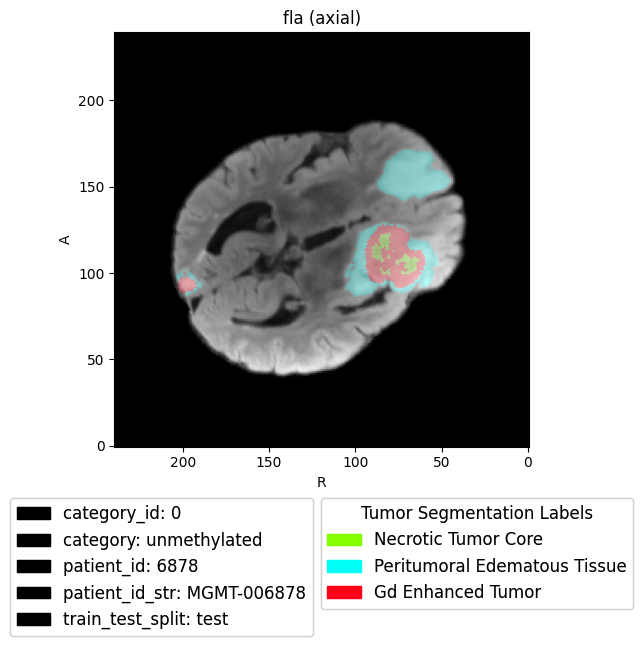

In [38]:
subject_transformed5 = RescaleIntensity(
    masking_method = lambda x: x > 0.0, # skull mask
    out_min_max = [-1, 1],
    percentiles = [0.5, 99.5],
)(subject_transformed4)

plot_subject_with_label(subject_transformed5, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

In [43]:
print(f"original min: {subject_transformed4.fla.tensor.min()}, transformed min: {subject_transformed5.fla.tensor.min()}")
print(f"original max: {subject_transformed4.fla.tensor.max()}, transformed max: {subject_transformed5.fla.tensor.max()}")

original min: -64.678955078125, transformed min: -1.0
original max: 1100.32958984375, transformed max: 1.0


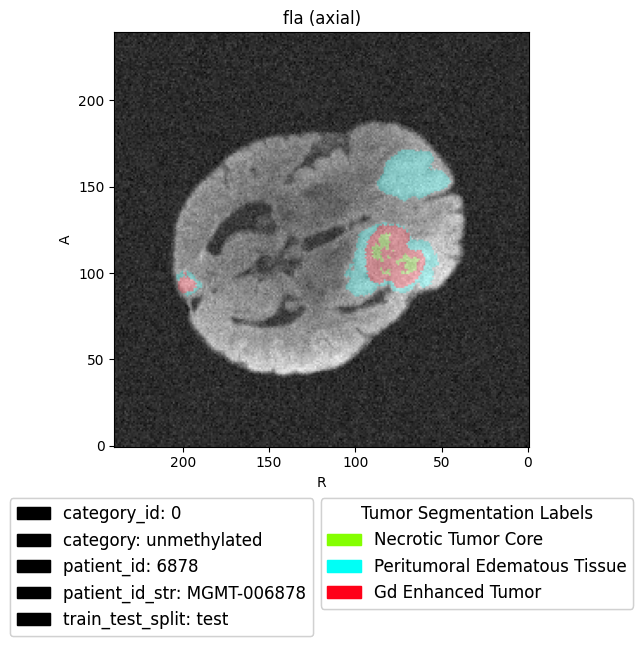

In [46]:
subject_transformed6 = tio.RandomNoise(
    p = 1.0,
    mean = [0.0, 0.0],
    std = [0.1, 0.1]  # greater than 0.1 looks pretty grainy
)(subject_transformed5)
subject_transformed6 = RescaleIntensity(out_min_max = [-1, 1])(subject_transformed6)

plot_subject_with_label(subject_transformed6, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

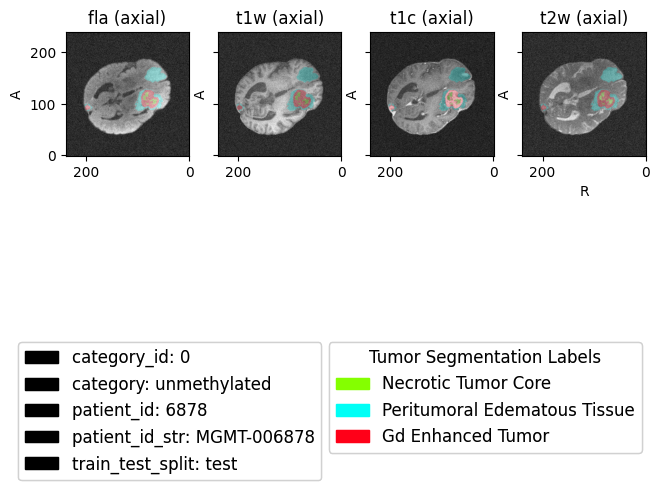

In [60]:
plot_subject_with_label(subject_transformed6, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial");

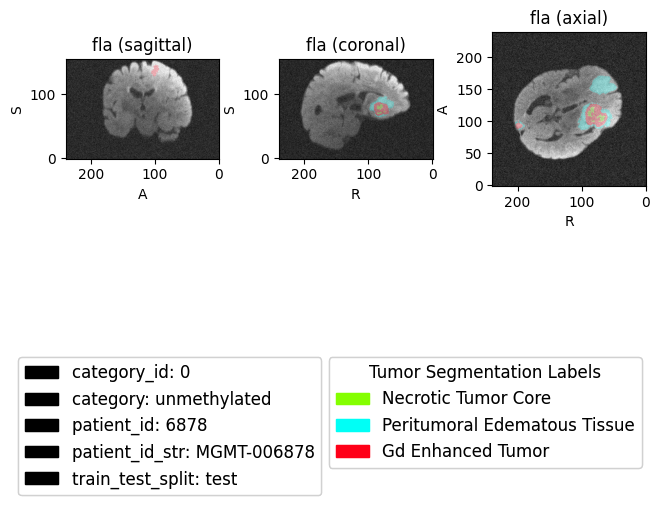

In [49]:
plot_subject_with_label(subject_transformed6, show=True, add_metadata=True, add_tumor_legend=True, subject_include=["fla"]);

In [52]:
subject_transformed7 = CropLargestTumor(crop_dim=None)(subject_transformed6)

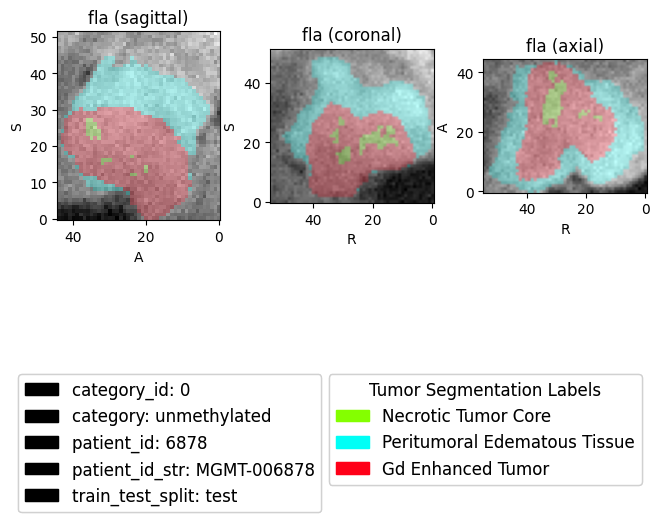

In [53]:
plot_subject_with_label(subject_transformed7, show=True, add_metadata=True, add_tumor_legend=True, subject_include=["fla"]);

In [55]:
subject_transformed6.fla

ScalarImage(shape: (1, 240, 240, 155); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.FloatTensor; memory: 34.1 MiB)

In [54]:
subject_transformed7.fla

ScalarImage(shape: (1, 55, 45, 52); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.FloatTensor; memory: 502.7 KiB)

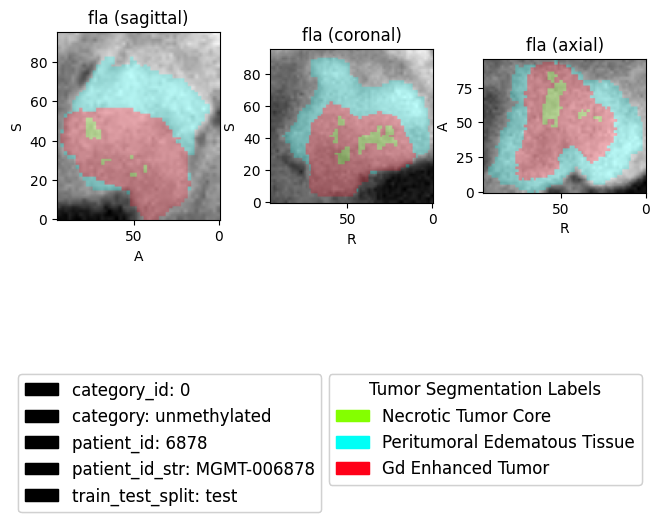

In [57]:
subject_transformed8 = tio.Resize(
    target_shape = [96, 96, 96],
    image_interpolation = "linear"
)(subject_transformed7)
plot_subject_with_label(subject_transformed8, show=True, add_metadata=True, add_tumor_legend=True, subject_include=["fla"]);

In [58]:
subject_transformed8.fla

ScalarImage(shape: (1, 96, 96, 96); spacing: (0.57, 0.47, 0.54); orientation: LPS+; dtype: torch.FloatTensor; memory: 3.4 MiB)

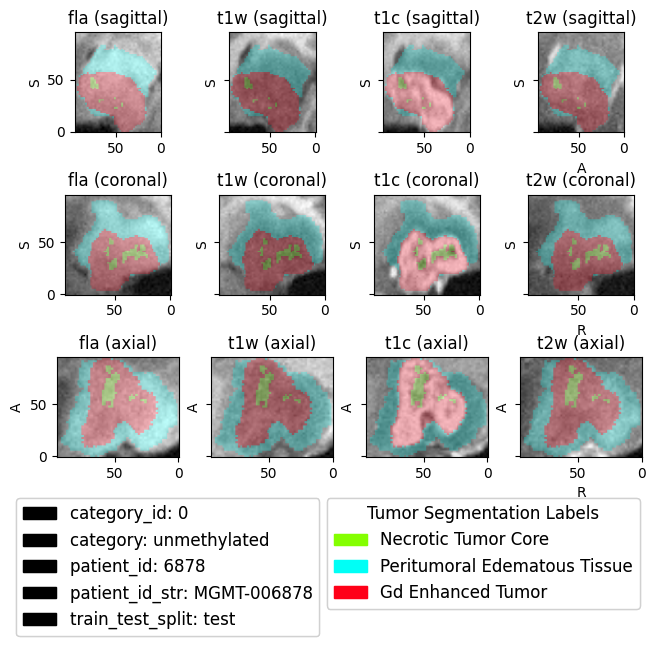

In [59]:
plot_subject_with_label(subject_transformed8, show=True, add_metadata=True, add_tumor_legend=True);